# Getting started with SCIFYsim

## Import the library

In [1]:
import scifysim as sf
import numpy as np
import matplotlib.pyplot as plt
# optional (when using dark interfaces)
plt.style.use("dark_background")

Building a model from scratch


In [2]:
my_target = "GJ 86 A"

In [3]:
print("SCIFYsim version: ", sf.version)
sf.logit.setLevel(sf.logging.ERROR)
t_exp =1.
seed = 10
expname = "R20_base_sensitivity"
save_results = False

SCIFYsim version:  0.2.2


In [41]:
configfile = "config/default_R20.ini"
output_dir = "/lhome/romain/Documents/hi5/meetings/simulator/tests/yield_testing/data/full_set/"

WARNING-astroquery- UnitsWarning: Unit 'e' not supported by the VOUnit standard. 
WARNING-astroquery- UnitsWarning: Unit 'Sun' not supported by the VOUnit standard. Did you mean uN?
ERROR-scifysim.utilities- Couldn't find the entry in JSDC catalog
Dist set to  10.786997784350653 [pc]
T set to  5263.5 [K]
R set to  0.77 [R_sun]


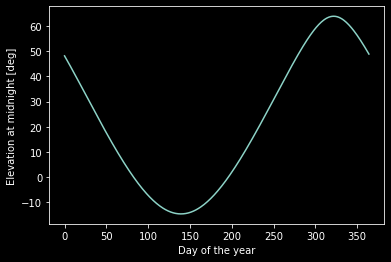

Best time: 2021-11-19T03:00:00.000
WARNING-astroquery- UnitsWarning: Unit 'e' not supported by the VOUnit standard. 
WARNING-astroquery- UnitsWarning: Unit 'Sun' not supported by the VOUnit standard. Did you mean uN?
Sequence start set to  2021-11-19T00:00:00.000
Sequence end set to  2021-11-19T06:00:00.000
ERROR-scifysim.injection- Now we use fpath to provide the root for appendix config files


0.010342691863670104
sep =  4.5
pa =  60.0
offset =  (-3.8971143170299736, 2.2500000000000004)
inside_tuning [ 0.00000000e+00 -3.88313942e-08  0.00000000e+00 -3.88315012e-08] [ 0.         -0.00014167  0.         -0.00014167]


In [5]:
asim = sf.utilities.prepare_all(configfile, thetarget=my_target, update_params=True,
                  instrumental_errors=True, seed=seed)
asim.combiner.chromatic_matrix(asim.lambda_science_range)

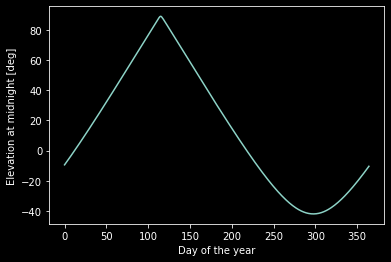

Best time: 2021-04-26T03:00:00.000
WARNING-astroquery- UnitsWarning: Unit 'e' not supported by the VOUnit standard. 
WARNING-astroquery- UnitsWarning: Unit 'Sun' not supported by the VOUnit standard. Did you mean uN?
Sequence start set to  2021-04-26T00:00:00.000
Sequence end set to  2021-04-26T06:00:00.000
ERROR-scifysim.injection- Now we use fpath to provide the root for appendix config files


0.010342691863670104
sep =  4.5
pa =  60.0
offset =  (-3.8971143170299736, 2.2500000000000004)
inside_tuning [ 0.00000000e+00 -3.88313942e-08  0.00000000e+00 -3.88315012e-08] [ 0.         -0.00014167  0.         -0.00014167]


In [6]:
asim.context = sf.analysis.spectral_context(asim.config)#("config/vega_R400.ini")

In [7]:
diffuse = [asim.src.sky, asim.src.UT, asim.src.warm_optics, asim.src.combiner, asim.src.cold_optics]


# Making some exposure

## First, point the instrument to your target

In [8]:
asim.point(asim.sequence[3], asim.target)

## Then you can start an integration

In [9]:
integ = asim.make_metrologic_exposure(asim.src.planet, asim.src.star, diffuse,
                                      texp=t_exp)
integ.prepare_t_exp_base()

integ.consolidate_metrologic()

100%|████████████████████████████████████████| 200/200 [00:01<00:00, 104.29it/s]


<IPython.core.display.Math object>

## Nice view of the results

In [10]:
shift_step = 1/(asim.n_spec_ch+2)
outputs = np.arange(integ.summed_signal.shape[2])
isources = np.arange(len(integ.sums))
raw_sources = [integ.static[0], integ.static[1],
               integ.static[2], integ.static[3],
               integ.static, integ.starlight, integ.planetlight]

(4, 8)


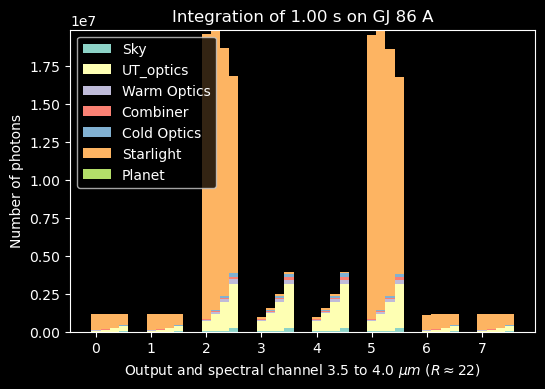

In [11]:
bottom = np.zeros_like(integ.sums[0])
pup = 1 # The pupil for which to plot the piston
print(integ.sums[0].shape)
signalplot = plt.figure(dpi=100)
bars = []
read_noise = integ.ron
for ksource, (thesource, label) in enumerate(zip(integ.sums, integ.source_labels)):
    photon_noise = np.sqrt(thesource)
    if ksource >= len(integ.static):
        inst_noise = np.std(raw_sources[ksource], axis=0)
    else:
        inst_noise = np.zeros((asim.lambda_science_range.shape[0], outputs.shape[0]))
    #print("Inst noise", ksource,  inst_noise.mean(axis=0))
    #print("Photon noise", ksource, photon_noise.mean(axis=0))
    noise = np.sqrt(photon_noise**2 + read_noise**2 + inst_noise**2)
    for ilamb in range(asim.lambda_science_range.shape[0]):
        #print(ksource, ilamb, label)
        #pdb.set_trace()
        if ilamb == 0:
            bars.append(plt.bar(outputs+shift_step*ilamb, thesource[ilamb,:], bottom=bottom[ilamb,:],
                label=label, width=shift_step, color="C%d"%ksource)) #yerr=noise[ilamb,:]
        else:
            bars.append(plt.bar(outputs+shift_step*ilamb, thesource[ilamb,:], bottom=bottom[ilamb,:],
                width=shift_step,  color="C%d"%ksource)) #yerr=noise[ilamb,:]
    bottom += thesource
#plt.legend((bars[i][0] for i in range(len(bars))), source_labels)
#Handled the legend with an condition in the loop
plt.legend(loc="upper left")
plt.xticks(outputs)
plt.xlabel(r"Output and spectral channel %.1f to %.1f $\mu m$ ($R\approx %.0f$)"%(asim.lambda_science_range[0]*1e6,
                                                                                 asim.lambda_science_range[-1]*1e6,
                                                                                 asim.R.mean()))
plt.title("Integration of %.2f s on %s"%(t_exp, asim.tarname))
plt.ylabel("Number of photons")
plt.show()

## Standard exposure


In [12]:
dit = 0.1
#estimation_computing = 2.8 # seconds to simulate a dit

In [13]:
import os
def sayit(text, showit=True):
    if showit: os.system("notify-send -i ~/Images/Python-logo-notext.svg -u critical '" + text + "'")
    os.system("spd-say -t female3 -x -r -50 '" + text + "'")

In [14]:
from time import time
start = time()
n_test = 10
for i in range(n_test):
    integ = asim.make_exposure(asim.src.planet, asim.src.star, diffuse,
                                texp=dit,
                                monitor_phase=False,
                               spectro=asim.spectro)
estimation_computing = (time()-start)/n_test
print(f"estimation: {estimation_computing} s/dit")

estimation: 0.2287053346633911 s/dit


# Full observing session (execute only once)

First run this sell to setup the length of the session and check computing time

In [15]:
from tqdm import tqdm
from astropy import time as atime
from datetime import datetime
#n_frames = 10
total_time = 3600*3  # Integration time (s)
approx_time = total_time / dit *estimation_computing
print(f"Simulating {total_time / dit} exposures representing:")
print(f"   {approx_time:.0f}", " seconds")
print(f"or {approx_time/60:.1f}", " minutes")
print(f"or {approx_time/3600:.3f}", " hours")

start_time = atime.Time(datetime.now())
from astropy.units import second
duration  = atime.TimeDelta(approx_time*second)
end_time = start_time + duration 
print("Estimated completion: ", end_time)

Simulating 108000.0 exposures representing:
   24700  seconds
or 411.7  minutes
or 6.861  hours
Estimated completion:  2022-05-17 05:37:41.515623


Then run the loop itself

In [16]:


nslots = len(asim.sequence)
n_frames = int(total_time/dit/nslots)
mynpix = 8
#diffuse = [asim.src.sky, asim.src.UT, asim.src.warm_optics, asim.src.combiner, asim.src.cold_optics]
screen_age = 0.
reveta = 1/integ.eta
full_record = True
s_datacube = []
s_dit_intensity = []
s_starlights = []
s_planetlights = []
for k, thetime in tqdm(enumerate(asim.sequence)):
    print(f"Doing chunk {k}/{len(asim.sequence)}")
    s_start = time()
    print("|", end="")
    asim.injector.update_screens()
    screen_age = 0.
    asim.point(thetime, asim.target)
    
    datacube = []
    dit_intensity = []
    starlights = []
    planetlights = []
    for i in range(n_frames):
        if screen_age>=20. :
            print("|", end="")
            asim.injector.update_screens()
            screen_age = 0.
        integ = asim.make_exposure(asim.src.planet, asim.src.star, diffuse,
                                    texp=dit,
                                    monitor_phase=False,
                                   spectro=None)
        datacube.append(integ.get_total(spectrograph=None,
                                        t_exp=dit,
                                        n_pixsplit=mynpix))
        dit_intensity.append(reveta * integ.forensics["Expectancy"].sum(axis=0))
        if full_record:
            starlights.append(integ.starlight.astype(np.float32))
            planetlights.append(integ.planetlight.astype(np.float32))
        integ.reset() # This can be removed after new kernel start
        screen_age += dit
    datacube = np.array(datacube)
    dit_intensity = np.array(dit_intensity)
    starlights = np.array(starlights)
    planetlights = np.array(planetlights)
    s_datacube.append(datacube)
    s_dit_intensity.append(dit_intensity)
    s_starlights.append(starlights)
    s_planetlights.append(planetlights)
    
    s_end = time()
    chunks_left = len(asim.sequence) - (k+1) 
    time_of_loop = s_end - s_start
    print(f"Finished in {(chunks_left * time_of_loop):.1f}s = {(chunks_left * time_of_loop)/3600:.2f}h")
s_datacube = np.array(s_datacube)
s_dit_intensity = np.array(s_dit_intensity)
s_starlights = np.array(s_starlights)
s_planetlights = np.array(s_planetlights)

0it [00:00, ?it/s]

Doing chunk 0/20
|||||||||||||||||||||||||||

1it [17:15, 1035.46s/it]

Finished in 19673.8s = 5.46h
Doing chunk 1/20
|||||||||||||||||||||||||||

2it [34:33, 1036.68s/it]

Finished in 18675.6s = 5.19h
Doing chunk 2/20
|||||||||||||||||||||||||||

3it [51:37, 1031.04s/it]

Finished in 17413.3s = 4.84h
Doing chunk 3/20
|||||||||||||||||||||||||||

4it [1:09:09, 1039.34s/it]

Finished in 16833.2s = 4.68h
Doing chunk 4/20
|||||||||||||||||||||||||||

5it [1:26:13, 1033.82s/it]

Finished in 15360.3s = 4.27h
Doing chunk 5/20
|||||||||||||||||||||||||||

6it [1:43:05, 1026.53s/it]

Finished in 14173.4s = 3.94h
Doing chunk 6/20
|||||||||||||||||||||||||||

7it [2:00:26, 1031.11s/it]

Finished in 13527.1s = 3.76h
Doing chunk 7/20
|||||||||||||||||||||||||||

8it [2:17:55, 1036.82s/it]

Finished in 12588.5s = 3.50h
Doing chunk 8/20
|||||||||||||||||||||||||||

9it [2:35:11, 1036.65s/it]

Finished in 11399.0s = 3.17h
Doing chunk 9/20
|||||||||||||||||||||||||||

10it [2:51:58, 1027.57s/it]

Finished in 10072.5s = 2.80h
Doing chunk 10/20
|||||||||||||||||||||||||||

11it [3:09:12, 1029.27s/it]

Finished in 9298.0s = 2.58h
Doing chunk 11/20
|||||||||||||||||||||||||||

12it [3:26:05, 1024.34s/it]

Finished in 8104.6s = 2.25h
Doing chunk 12/20
|||||||||||||||||||||||||||

13it [3:42:42, 1016.08s/it]

Finished in 6979.4s = 1.94h
Doing chunk 13/20
|||||||||||||||||||||||||||

14it [3:59:19, 1010.46s/it]

Finished in 5984.9s = 1.66h
Doing chunk 14/20
|||||||||||||||||||||||||||

15it [4:16:01, 1007.90s/it]

Finished in 5009.9s = 1.39h
Doing chunk 15/20
|||||||||||||||||||||||||||

16it [4:33:13, 1015.25s/it]

Finished in 4129.2s = 1.15h
Doing chunk 16/20
|||||||||||||||||||||||||||

17it [4:49:45, 1008.10s/it]

Finished in 2974.5s = 0.83h
Doing chunk 17/20
|||||||||||||||||||||||||||

18it [5:06:25, 1005.66s/it]

Finished in 1999.9s = 0.56h
Doing chunk 18/20
|||||||||||||||||||||||||||

19it [5:23:08, 1004.79s/it]

Finished in 1002.8s = 0.28h
Doing chunk 19/20
|||||||||||||||||||||||||||

20it [5:40:20, 1021.04s/it]

Finished in 0.0s = 0.00h


In [21]:
s_datacube.shape
spectral_res = 20.
np.save(f"{output_dir}test_R{spectral_res:.0f}_20_{total_time/3600:.1f}",s_datacube, )
np.save(f"{output_dir}test_idealI_R{spectral_res:.0f}_20_{total_time/3600:.1f}",s_dit_intensity, )

In [22]:
sayit("All done!")

# Create a noiseless simulator

Note the parameter `instrumental_errors=False`.

WARNING-astroquery- UnitsWarning: Unit 'e' not supported by the VOUnit standard. 
WARNING-astroquery- UnitsWarning: Unit 'Sun' not supported by the VOUnit standard. Did you mean uN?
ERROR-scifysim.utilities- Couldn't find the entry in JSDC catalog


Dist set to  10.786997784350653 [pc]
T set to  5263.5 [K]
R set to  0.77 [R_sun]


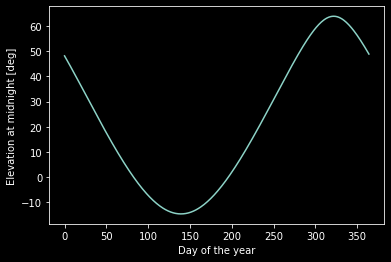

Best time: 2021-11-19T03:00:00.000
WARNING-astroquery- UnitsWarning: Unit 'e' not supported by the VOUnit standard. 
WARNING-astroquery- UnitsWarning: Unit 'Sun' not supported by the VOUnit standard. Did you mean uN?
Sequence start set to  2021-11-19T00:00:00.000
Sequence end set to  2021-11-19T06:00:00.000
ERROR-scifysim.injection- Now we use fpath to provide the root for appendix config files


0.010342691863670104
sep =  4.5
pa =  60.0
offset =  (-3.8971143170299736, 2.2500000000000004)
inside_tuning [ 0.00000000e+00 -3.88313942e-08  0.00000000e+00 -3.88315012e-08] [ 0.         -0.00014167  0.         -0.00014167]


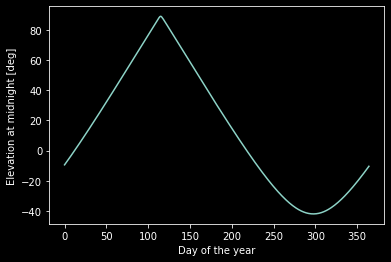

Best time: 2021-04-26T03:00:00.000
WARNING-astroquery- UnitsWarning: Unit 'e' not supported by the VOUnit standard. 
WARNING-astroquery- UnitsWarning: Unit 'Sun' not supported by the VOUnit standard. Did you mean uN?
Sequence start set to  2021-04-26T00:00:00.000
Sequence end set to  2021-04-26T06:00:00.000
ERROR-scifysim.injection- Now we use fpath to provide the root for appendix config files


0.010342691863670104
sep =  4.5
pa =  60.0
offset =  (-3.8971143170299736, 2.2500000000000004)
inside_tuning [ 0.00000000e+00 -3.88313942e-08  0.00000000e+00 -3.88315012e-08] [ 0.         -0.00014167  0.         -0.00014167]


In [23]:
perfect_sim = sf.utilities.prepare_all(asim.config, thetarget=my_target, update_params=True,
                  instrumental_errors=False, seed=seed)
perfect_sim.combiner.chromatic_matrix(perfect_sim.lambda_science_range)
perfect_sim.context = sf.analysis.spectral_context(perfect_sim.config)#("config/vega_R400.ini")
diffuse = [perfect_sim.src.sky, perfect_sim.src.UT, perfect_sim.src.warm_optics, perfect_sim.src.combiner, perfect_sim.src.cold_optics]

In [32]:
nslots = len(perfect_sim.sequence)
n_frames = 1
mynpix = 8
#diffuse = [perfect_sim.src.sky, perfect_sim.src.UT, perfect_sim.src.warm_optics, perfect_sim.src.combiner, perfect_sim.src.cold_optics]
screen_age = 0.
reveta = 1/integ.eta
full_record = True
p_datacube = []
p_dit_intensity = []
p_starlights = []
p_planetlights = []
for k, thetime in tqdm(enumerate(perfect_sim.sequence)):
    print(f"Doing chunk {k}/{len(perfect_sim.sequence)}")
    p_start = time()
    print("|", end="")
    perfect_sim.injector.update_screens()
    screen_age = 0.
    perfect_sim.point(thetime, perfect_sim.target)
    
    datacube = []
    dit_intensity = []
    starlights = []
    planetlights = []
    for i in range(n_frames):
        if screen_age>=20. :
            print("|", end="")
            perfect_sim.injector.update_screens()
            screen_age = 0.
        integ = perfect_sim.make_exposure(perfect_sim.src.planet, perfect_sim.src.star, diffuse,
                                    texp=dit,
                                    monitor_phase=False,
                                   spectro=None)
        datacube.append(integ.get_total(spectrograph=None,
                                        t_exp=dit,
                                        n_pixsplit=mynpix))
        dit_intensity.append(reveta * integ.forensics["Expectancy"].sum(axis=0))
        if full_record:
            starlights.append(integ.starlight.astype(np.float32))
            planetlights.append(integ.planetlight.astype(np.float32))
        integ.reset() # This can be removed after new kernel start
        screen_age += dit
    datacube = np.array(datacube)
    dit_intensity = np.array(dit_intensity)
    starlights = np.array(starlights)
    planetlights = np.array(planetlights)
    p_datacube.append(datacube)
    p_dit_intensity.append(dit_intensity)
    p_starlights.append(starlights)
    p_planetlights.append(planetlights)
    
    p_end = time()
    chunks_left = len(perfect_sim.sequence) - (k+1) 
    time_of_loop = p_end - p_start
    print(f"Finished in {(chunks_left * time_of_loop):.1f}s = {(chunks_left * time_of_loop)/3600:.2f}h")
p_datacube = np.array(p_datacube)
p_dit_intensity = np.array(p_dit_intensity)
p_starlights = np.array(p_starlights)
p_planetlights = np.array(p_planetlights)

0it [00:00, ?it/s]

Doing chunk 0/20
|

1it [00:00,  1.86it/s]

Finished in 10.2s = 0.00h
Doing chunk 1/20
|

2it [00:01,  1.82it/s]

Finished in 10.0s = 0.00h
Doing chunk 2/20
|

3it [00:01,  1.80it/s]

Finished in 9.5s = 0.00h
Doing chunk 3/20
|

4it [00:02,  1.85it/s]

Finished in 8.2s = 0.00h
Doing chunk 4/20
|

5it [00:02,  1.88it/s]

Finished in 7.8s = 0.00h
Doing chunk 5/20
|

6it [00:03,  1.91it/s]

Finished in 7.1s = 0.00h
Doing chunk 6/20
|

7it [00:03,  1.91it/s]

Finished in 6.8s = 0.00h
Doing chunk 7/20
|

8it [00:04,  1.91it/s]

Finished in 6.3s = 0.00h
Doing chunk 8/20
|

9it [00:04,  1.91it/s]

Finished in 5.7s = 0.00h
Doing chunk 9/20
|

10it [00:05,  1.93it/s]

Finished in 5.1s = 0.00h
Doing chunk 10/20
|

11it [00:05,  1.89it/s]

Finished in 4.9s = 0.00h
Doing chunk 11/20
|

12it [00:06,  1.91it/s]

Finished in 4.1s = 0.00h
Doing chunk 12/20
|

13it [00:06,  1.93it/s]

Finished in 3.5s = 0.00h
Doing chunk 13/20
|

14it [00:07,  1.93it/s]

Finished in 3.1s = 0.00h
Doing chunk 14/20
|

15it [00:07,  1.89it/s]

Finished in 2.8s = 0.00h
Doing chunk 15/20
|

16it [00:08,  1.89it/s]

Finished in 2.1s = 0.00h
Doing chunk 16/20
|

17it [00:08,  1.90it/s]

Finished in 1.6s = 0.00h
Doing chunk 17/20
|

18it [00:09,  1.92it/s]

Finished in 1.0s = 0.00h
Doing chunk 18/20
|

19it [00:10,  1.89it/s]

Finished in 0.5s = 0.00h
Doing chunk 19/20
|

20it [00:10,  1.90it/s]

Finished in 0.0s = 0.00h


In [33]:
p_planetlights.shape

(20, 1, 4, 8)

The raw data noise file has a shape \[chunk, nframes, nspectralchannels, noutputs\].

In [42]:
noisebatch = np.load(f"{output_dir}test_R20_20_3.0.npy") 
print(noisebatch.shape)

(20, 5400, 4, 8)


To first approximation, it acts additively, so you can just add it like this (here to create 60 frames per chunk). You could go as high as `noisebatch.shape[1]`:

In [43]:
renoised_data = p_planetlights + noisebatch[:,:60,:,:]

In [44]:
renoised_data.shape

(20, 60, 4, 8)

## The combiner matrix